In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from datetime import datetime
import pytz
from wordcloud import WordCloud
from nltk.util import ngrams

# Download NLTK Ressourcen
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")

# Load dataset
df = pd.read_csv("../data/posts_hashtags_selected_columns.csv")
# Convert timestamp column to datetime
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"])

# Filter to last 6 months
from datetime import datetime
six_months_ago = pd.Timestamp(datetime.today() - pd.DateOffset(months=6), tz="UTC")
df = df[df["createTimeISO"] >= six_months_ago]

# Keep only rows with non-empty captions and remove hashtags
df = df[df["text"].notna()]
df["text"] = df["text"].astype(str).apply(lambda x: re.sub(r"#\w+", "", x))

# Define standard and custom stopwords
standard_stopwords = set(stopwords.words("german")) | set(stopwords.words("english"))
custom_stopwords = {
    "i", "you", "it", "me", "this", "that", "we", "she", "he", "they", "u", "ur",
    "my", "your", "yours", "ours", "their", "its", "use", "like", "get", "need", 
    "please", "one", "would", "watch", "want", "que", "tbh", "idk", "fr", 
    "literally", "actually", "honestly", "kinda", "thing", "stuff", 
    "😭", "😂", "✨", "💀", "💅", "🥰", "😩", "😅", "🥺", "😳"
}

# combined stopwords (standard + custom)
combined_stopwords = standard_stopwords | custom_stopwords

# Clean text and tokenize it
def clean_tokens(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)  # keep only letters
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in combined_stopwords and len(w) > 2]
    return tokens

# Apply tokenization to all captions
df["tokens"] = df["text"].apply(clean_tokens)


[nltk_data] Downloading package punkt to C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 5 most common words per week

In [16]:
# Add week column
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Explode tokens
df_exploded = df.explode("tokens")

# Calculate top 5 words per week
weekly_words = (
    df_exploded.groupby("week")["tokens"]
    .apply(lambda x: Counter(x).most_common(5))
)

# Reset index to turn week into a column
df_topwords = weekly_words.reset_index()

# Rename for clarity
df_topwords.columns = ["week", "top_words"]

# Explode list of tuples
df_topwords = df_topwords.explode("top_words")

# Split tuple into two columns
df_topwords[["word", "count"]] = pd.DataFrame(df_topwords["top_words"].tolist(), index=df_topwords.index)

# add rank
df_topwords["rank"] = df_topwords.groupby("week").cumcount() + 1

# Final tidy table
df_topwords = df_topwords[["week", "rank", "word", "count"]]

# Sort by newest week
df_topwords = df_topwords.sort_values("week", ascending=False)

# Show it
df_topwords.head(20)

C:\Users\Surface\AppData\Local\Temp\ipykernel_14600\756048235.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


,week,rank,word,count
20,2025-03-24,5,routine,281
20,2025-03-24,4,glow,297
20,2025-03-24,3,skin,394
20,2025-03-24,2,skincare,411
20,2025-03-24,1,haut,883
19,2025-03-17,5,feuchtigkeit,264
19,2025-03-17,4,skincare,307
19,2025-03-17,3,glow,380
19,2025-03-17,2,skin,386
19,2025-03-17,1,haut,1377


Most common words and phrases

In [ ]:
# Tokenisation
df["caption_tokens"] = df["text"].apply(lambda x: [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in combined_stopwords])

# Flattened unigram list
all_unigrams = [word for tokens in df["caption_tokens"] for word in tokens]

# Flattened bigram and trigram lists
all_bigrams = [" ".join(bg) for tokens in df["caption_tokens"] for bg in ngrams(tokens, 2)]
all_trigrams = [" ".join(tg) for tokens in df["caption_tokens"] for tg in ngrams(tokens, 3)]

# Top 10
top10_unigrams = Counter(all_unigrams).most_common(10)
top10_bigrams = Counter(all_bigrams).most_common(10)
top10_trigrams = Counter(all_trigrams).most_common(10)

# Convert to DataFrames
df_uni = pd.DataFrame(top10_unigrams, columns=["Unigram", "Unigram Count"])
df_bi = pd.DataFrame(top10_bigrams, columns=["Bigram", "Bigram Count"])
df_tri = pd.DataFrame(top10_trigrams, columns=["Trigram", "Trigram Count"])

# Combine side by side
df_side_by_side = pd.concat([df_uni, df_bi, df_tri], axis=1)

# Display
df_side_by_side

,Unigram,Unigram Count,Bigram,Bigram Count,Trigram,Trigram Count
0,haut,5058,skincare routine,424,skinglow aqua instagram,181
1,skincare,2000,strahlende haut,274,l oréal paris,118
2,skin,1722,skinglow aqua,181,aqua facial behandlung,94
3,glow,1169,aqua instagram,181,facial behandlung aktuell,94
4,routine,1074,empfindliche haut,167,behandlung aktuell statt,94
5,feuchtigkeit,788,intensiv feuchtigkeit,164,aktuell statt folgt,94
6,serum,760,eye cream,162,statt folgt gerne,94
7,pflege,632,aqua facial,155,folgt gerne instagram,94
8,cream,600,l oréal,154,haut intensiv feuchtigkeit,87
9,products,580,anti aging,154,home tester club,80


In [26]:
# Get the most recent week
latest_week = df["week"].max()

# Filter to latest week
df_latest = df[df["week"] == latest_week]

# Tokenization (if not already done for this week)
df_latest["caption_tokens"] = df_latest["text"].apply(
    lambda x: [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in combined_stopwords]
)

# Create ngram lists
unigrams_latest = [word for tokens in df_latest["caption_tokens"] for word in tokens]
bigrams_latest = [" ".join(bg) for tokens in df_latest["caption_tokens"] for bg in ngrams(tokens, 2)]
trigrams_latest = [" ".join(tg) for tokens in df_latest["caption_tokens"] for tg in ngrams(tokens, 3)]

# Total counts for normalization
total_unigrams = len(unigrams_latest)
total_bigrams = len(bigrams_latest)
total_trigrams = len(trigrams_latest)

# Top 10 counters
top10_unigrams = Counter(unigrams_latest).most_common(10)
top10_bigrams = Counter(bigrams_latest).most_common(10)
top10_trigrams = Counter(trigrams_latest).most_common(10)

# Convert to DataFrames with percentage
df_uni = pd.DataFrame(top10_unigrams, columns=["Unigram", "Unigram Count"])
df_uni["Unigram %"] = (df_uni["Unigram Count"] / total_unigrams) * 100

df_bi = pd.DataFrame(top10_bigrams, columns=["Bigram", "Bigram Count"])
df_bi["Bigram %"] = (df_bi["Bigram Count"] / total_bigrams) * 100

df_tri = pd.DataFrame(top10_trigrams, columns=["Trigram", "Trigram Count"])
df_tri["Trigram %"] = (df_tri["Trigram Count"] / total_trigrams) * 100

# Keep only relevant columns
df_uni = df_uni[["Unigram", "Unigram %"]]
df_bi = df_bi[["Bigram", "Bigram %"]]
df_tri = df_tri[["Trigram", "Trigram %"]]

# Combine side-by-side and round
df_relative_latest_week = pd.concat([df_uni, df_bi, df_tri], axis=1).round(2)

# Output info and display table
print("Top 10 Ngrams in Captions – Relative Frequencies")
print(f"Week starting: {latest_week.strftime('%Y-%m-%d')}\n")

df_relative_latest_week

C:\Users\Surface\AppData\Local\Temp\ipykernel_14600\487886639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest["caption_tokens"] = df_latest["text"].apply(


Top 10 Ngrams in Captions – Relative Frequencies
Week starting: 2025-03-24



,Unigram,Unigram %,Bigram,Bigram %,Trigram,Trigram %
0,haut,2.79,night routine,0.30,versorgt haut intensiv,0.19
1,skincare,1.30,garnier garnier,0.30,haut intensiv feuchtigkeit,0.19
2,skin,1.25,eye cream,0.20,frühjahrsneuheiten vielen dank,0.19
3,power,0.78,power luxe,0.20,zara beauty ort,0.17
4,glow,0.74,power lift,0.20,beauty ort schönheit,0.17
5,routine,0.66,power serum,0.20,ort schönheit entspannung,0.17
6,garnier,0.63,rice moisture,0.20,schönheit entspannung ludwigstraße,0.17
7,face,0.62,haut sichtbar,0.19,entspannung ludwigstraße infos,0.17
8,night,0.58,strahlende haut,0.19,effektiv ganz op,0.17
9,serum,0.57,versorgt haut,0.19,weekly night reset,0.15


Wordcloud of most common words for last 6 months

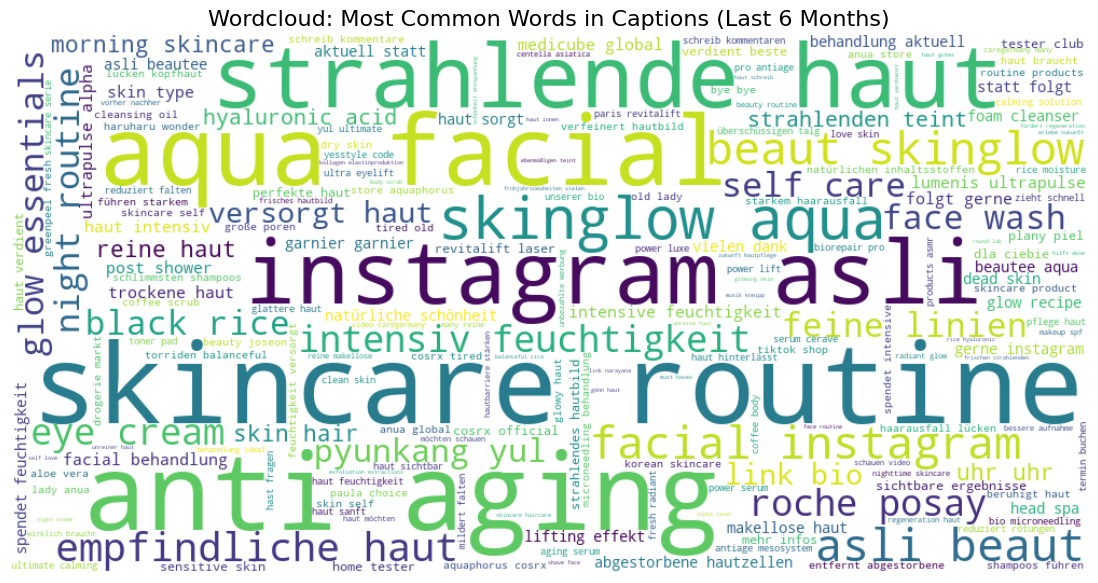

In [19]:
# Alle Tokens aus dem DataFrame (Liste von Listen → flach machen)
all_tokens = df["tokens"].explode().dropna()

# Join all tokens into a single string
text = " ".join(all_tokens)

# Generate wordcloud
wc = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(text)

# Show wordcloud
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud: Most Common Words in Captions (Last 6 Months)", fontsize=16)
plt.show()

C:\Users\Surface\AppData\Local\Temp\ipykernel_14600\127930649.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


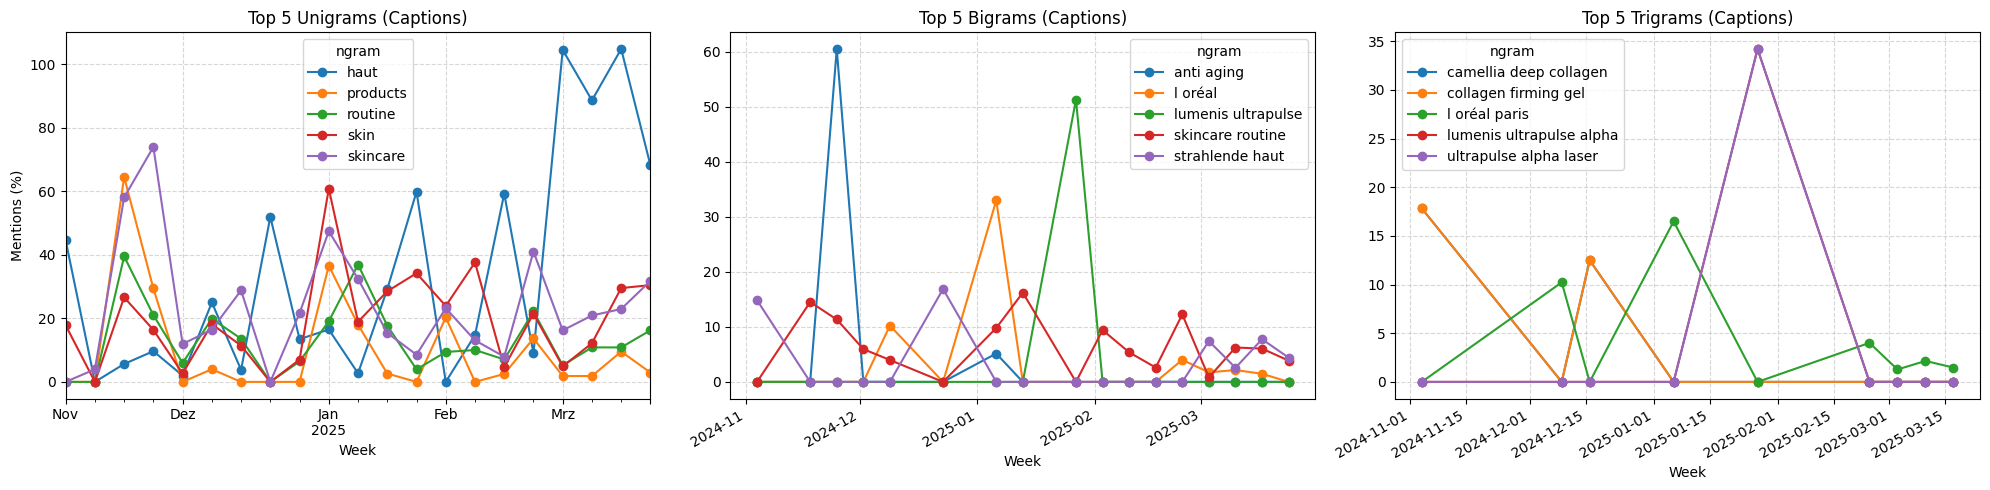

In [27]:
# Week column (if not already present)
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Tokenize captions (if not already done)
df["caption_tokens"] = df["text"].apply(lambda x: [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in combined_stopwords])

# Create unigrams, bigrams, trigrams
df["unigrams"] = df["caption_tokens"]
df["bigrams"] = df["caption_tokens"].apply(lambda tokens: [" ".join(g) for g in ngrams(tokens, 2)])
df["trigrams"] = df["caption_tokens"].apply(lambda tokens: [" ".join(g) for g in ngrams(tokens, 3)])

# Combine all ngrams into one list per row
df["all_ngrams"] = df["unigrams"] + df["bigrams"] + df["trigrams"]

# Create flat list: (week, ngram)
records = [(row["week"], ngram) for _, row in df.iterrows() for ngram in row["all_ngrams"]]
df_all = pd.DataFrame(records, columns=["week", "ngram"])

# Count ngram mentions per week
weekly_counts = df_all.groupby(["week", "ngram"]).size().reset_index(name="count")

# Total number of captions per week
captions_per_week = df.groupby("week")["text"].count().reset_index(name="total_captions")

# Merge and normalize
weekly_counts = weekly_counts.merge(captions_per_week, on="week", how="left")
weekly_counts["mention_percent"] = (weekly_counts["count"] / weekly_counts["total_captions"]) * 100

# Helper function: classify ngram by word count
def get_ngram_type(ngram):
    if len(ngram.split()) == 1:
        return "Unigram"
    elif len(ngram.split()) == 2:
        return "Bigram"
    else:
        return "Trigram"

# Assign type
weekly_counts["type"] = weekly_counts["ngram"].apply(get_ngram_type)

# Top 5 per type across the full period
top_ngrams_by_type = (
    weekly_counts.groupby(["type", "ngram"])["mention_percent"]
    .sum()
    .reset_index()
    .sort_values(["type", "mention_percent"], ascending=[True, False])
    .groupby("type")
    .head(5)
)

# Filter weekly counts
top_weekly = weekly_counts.merge(top_ngrams_by_type[["type", "ngram"]], on=["type", "ngram"])

# Pivot for each ngram type
df_uni = top_weekly[top_weekly["type"] == "Unigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)
df_bi = top_weekly[top_weekly["type"] == "Bigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)
df_tri = top_weekly[top_weekly["type"] == "Trigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

df_uni.plot(ax=axes[0], marker="o")
axes[0].set_title("Top 5 Unigrams (Captions)")
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Mentions (%)")
axes[0].grid(True, linestyle="--", alpha=0.5)

df_bi.plot(ax=axes[1], marker="o")
axes[1].set_title("Top 5 Bigrams (Captions)")
axes[1].set_xlabel("Week")
axes[1].grid(True, linestyle="--", alpha=0.5)

df_tri.plot(ax=axes[2], marker="o")
axes[2].set_title("Top 5 Trigrams (Captions)")
axes[2].set_xlabel("Week")
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Top keyword trends per week (last 6 monts)

In [20]:
# Step 1: Create 'week' column from timestamp
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Step 2: Explode token list into one word per row
df_weekly = df.explode("tokens")

# Step 3: Count how often each word appears per week
word_counts = df_weekly.groupby(["week", "tokens"]).size().reset_index(name="count")

# Step 4: Optional - keep only words that occur more than 20 times overall
top_words = word_counts.groupby("tokens")["count"].sum()
top_words = top_words[top_words > 20].index  # adjust threshold if needed

# Step 5: Filter word_counts to keep only top words
filtered = word_counts[word_counts["tokens"].isin(top_words)]

# Step 6: Create pivot table (words as rows, weeks as columns)
pivot_weekly = filtered.pivot_table(
    index="tokens", columns="week", values="count", fill_value=0
)

# Step 7: Sort by total mentions across all weeks (optional)
pivot_weekly["total"] = pivot_weekly.sum(axis=1)
pivot_weekly = pivot_weekly.sort_values("total", ascending=False).drop(columns="total")

# Step 8: Count number of posts per week (not exploded)
weekly_post_counts = df.groupby("week").size()

# Step 9: Convert to DataFrame row and label it
weekly_post_counts = pd.DataFrame([weekly_post_counts])
weekly_post_counts.index = ["total_posts"]

# Step 10: Combine with pivot table (add total_posts as first row)
pivot_with_totals = pd.concat([weekly_post_counts, pivot_weekly])

# Step 11: Display top 15 words (+ total_posts)
pivot_with_totals.head(16)

C:\Users\Surface\AppData\Local\Temp\ipykernel_14600\1351726904.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


week,2024-11-04,2024-11-11,2024-11-18,2024-11-25,2024-12-02,2024-12-09,2024-12-16,2024-12-23,2024-12-30,2025-01-06,...,2025-01-20,2025-01-27,2025-02-03,2025-02-10,2025-02-17,2025-02-24,2025-03-03,2025-03-10,2025-03-17,2025-03-24
total_posts,101.0,126.0,124.0,238.0,151.0,176.0,184.0,77.0,171.0,194.0,...,305.0,152.0,138.0,428.0,921.0,424.0,863.0,976.0,1290.0,1293.0
haut,45.0,0.0,7.0,23.0,3.0,44.0,7.0,40.0,23.0,32.0,...,89.0,91.0,0.0,63.0,581.0,38.0,951.0,883.0,1377.0,883.0
skincare,0.0,5.0,72.0,176.0,18.0,29.0,53.0,13.0,87.0,92.0,...,47.0,14.0,32.0,56.0,84.0,175.0,163.0,204.0,307.0,411.0
skin,18.0,0.0,33.0,67.0,4.0,32.0,44.0,0.0,12.0,118.0,...,127.0,65.0,33.0,182.0,60.0,104.0,54.0,158.0,386.0,394.0
glow,18.0,0.0,66.0,18.0,0.0,18.0,15.0,0.0,3.0,0.0,...,0.0,26.0,0.0,29.0,163.0,27.0,134.0,144.0,380.0,297.0
routine,0.0,0.0,49.0,50.0,9.0,69.0,25.0,13.0,11.0,37.0,...,54.0,6.0,13.0,43.0,87.0,96.0,60.0,106.0,162.0,281.0
beauty,15.0,0.0,18.0,10.0,0.0,0.0,23.0,0.0,3.0,19.0,...,0.0,32.0,5.0,0.0,74.0,62.0,149.0,61.0,131.0,257.0
feuchtigkeit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,54.0,1.0,0.0,0.0,12.0,0.0,137.0,144.0,264.0,171.0
serum,0.0,0.0,0.0,96.0,0.0,10.0,0.0,0.0,33.0,15.0,...,0.0,0.0,14.0,88.0,32.0,76.0,20.0,7.0,144.0,181.0
pflege,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,0.0,0.0,62.0,1.0,238.0,65.0,207.0,69.0


Top keywords over time

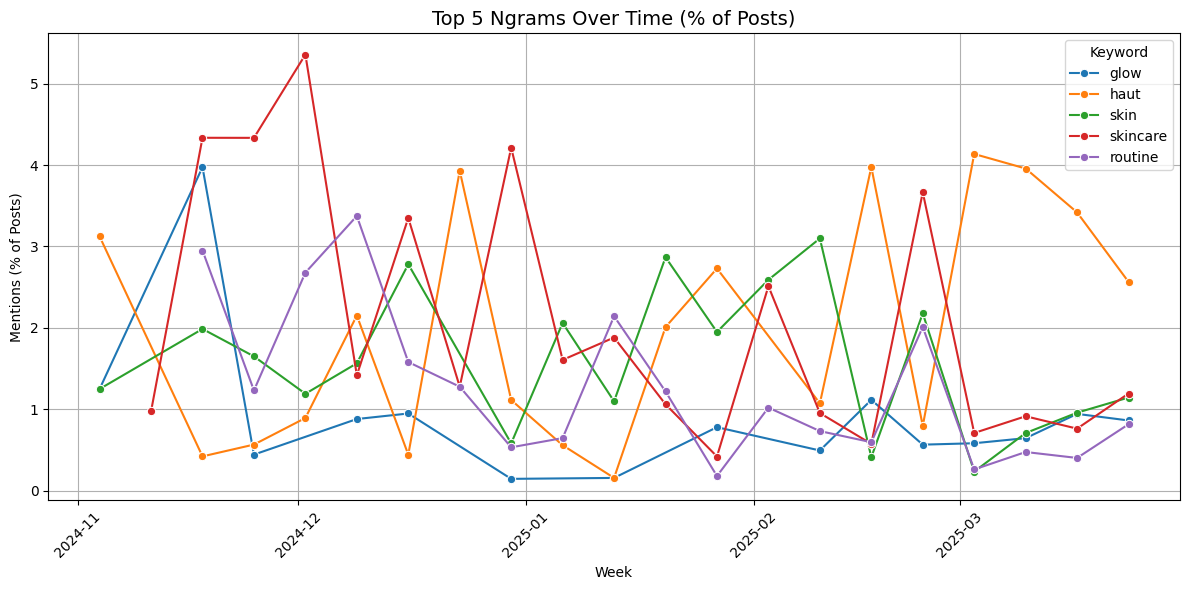

In [21]:
# Count all ngram mentions (e.g. from 'tokens' column) over the whole period
top_ngrams = (
    df_exploded["tokens"]
    .value_counts()
    .head(5)
    .index
    .tolist()
)

# Filter only those top 5 ngrams
df_top_ngrams = df_exploded[df_exploded["tokens"].isin(top_ngrams)]

# Group and count
trend_data = (
    df_top_ngrams.groupby(["week", "tokens"])
    .size()
    .reset_index(name="count")
)

# Total posts per week
posts_per_week = df_exploded.groupby("week")["text"].count().reset_index(name="total_posts")

# Merge and normalize
trend_data = trend_data.merge(posts_per_week, on="week", how="left")
trend_data["mention_percent"] = (trend_data["count"] / trend_data["total_posts"]) * 100

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x="week", y="mention_percent", hue="tokens", marker="o")
plt.title("Top 5 Ngrams Over Time (% of Posts)", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Mentions (% of Posts)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Keyword")
plt.show()


Top trending keywords - 4 weeks growth

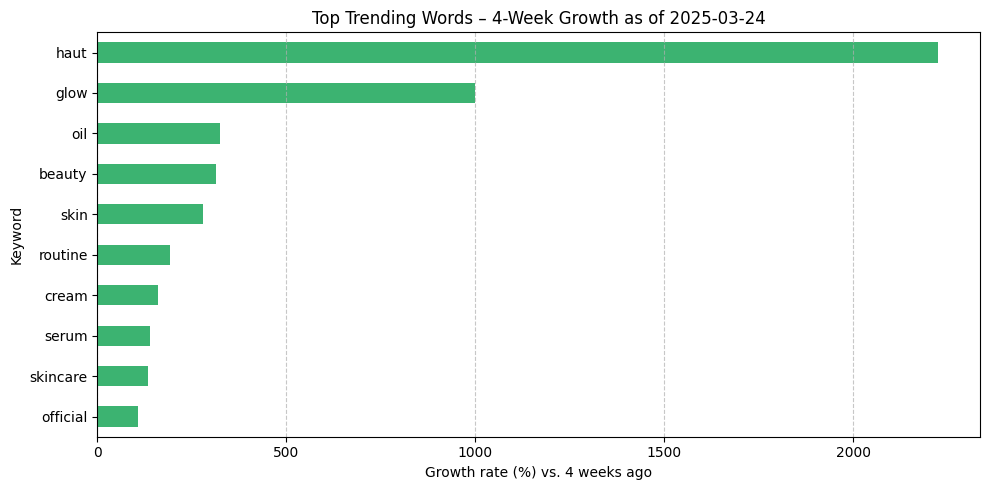

In [25]:
# Get the most recent and the one before that (4 weeks ago)
latest_week = pivot_weekly.columns[-1]
previous_week = pivot_weekly.columns[-5]  # 4 weeks ago

# Calculate percentage growth, avoiding division by zero
previous_counts = pivot_weekly[previous_week].replace(0, 1)
growth_2w = ((pivot_weekly[latest_week] - pivot_weekly[previous_week]) / previous_counts) * 100

# Keep only words that appear at least 50 times in the latest week
min_count = 50
min_previous = 25 # Minimum count in the previous week
valid_words = (pivot_weekly[latest_week] >= min_count) & (pivot_weekly[previous_week] >= min_previous)
trending_2w = growth_2w[valid_words].sort_values(ascending=False)

# Select top 10 trending words
top_trending = trending_2w.head(10)

# Visualize
plt.figure(figsize=(10, 5))
top_trending[::-1].plot(kind="barh", color="mediumseagreen")
plt.title(f"Top Trending Words – 4-Week Growth as of {latest_week.date()}")
plt.xlabel("Growth rate (%) vs. 4 weeks ago")
plt.ylabel("Keyword")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Trending words over time

<Figure size 1600x600 with 0 Axes>

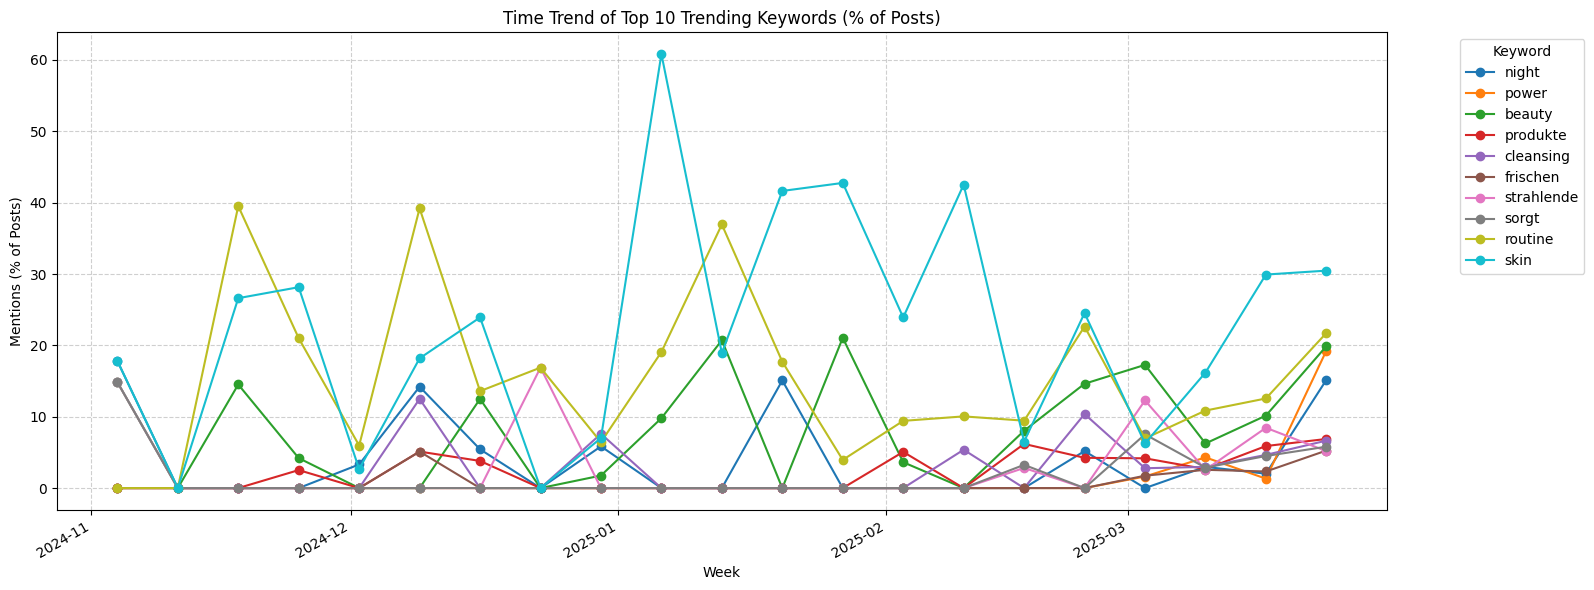

In [23]:
# Number of trending words to show
top_n = 10

# Get the top trending words from 2-week growth analysis
top_trending_words = trending_2w.head(top_n).index.tolist()

# Filter the pivot table to include only those trending words
pivot_trending = pivot_weekly.loc[top_trending_words]

# Transpose so weeks are rows, words are columns
pivot_trending = pivot_trending.T  # index = week, columns = keywords

# Get number of posts per week
posts_per_week = df.groupby(df["week"])["tokens"].count()
posts_per_week.name = "total_posts"

# Normalize keyword mentions by total posts per week
pivot_trending_normalized = pivot_trending.div(posts_per_week, axis=0) * 100  # in percent

# Plot
plt.figure(figsize=(16, 6))
pivot_trending_normalized.plot(marker='o', figsize=(16, 6))
plt.title(f"Time Trend of Top {top_n} Trending Keywords (% of Posts)")
plt.xlabel("Week")
plt.ylabel("Mentions (% of Posts)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Most common chunks

In [24]:
#import spacy
#from langdetect import detect, DetectorFactory
#from collections import Counter
#import re

# Fix randomness in language detection
#DetectorFactory.seed = 0

# Load spacy models
#nlp_de = spacy.load("de_core_news_sm")
#nlp_en = spacy.load("en_core_web_sm")

# Emoji regex pattern
#emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

# Function: check for emojis
#def contains_emoji(text):
 #   return bool(emoji_pattern.search(text))

# Function: detect valid language
#def is_valid_language(text):
 #   try:
  #      lang = detect(text)
   #     return lang in ["en", "de"]
    #except:
     #   return False

# Function: extract and clean chunks
#def extract_clean_chunks(text, stopwords):
 #   if not is_valid_language(text):
  #      return []

    # Choose model by presence of German umlauts
  #  nlp = nlp_de if any(umlaut in text for umlaut in "äöüß") else nlp_en
  #  doc = nlp(text)
  #  chunks = []
  #  for chunk in doc.noun_chunks:
  #      phrase = chunk.text.lower().strip()
   #     if len(phrase.split()) <= 1:
    #        continue  # only multi-word chunks
     #   if any(word in stopwords for word in phrase.split()):
      #      continue  # skip if any word is a stopword
       # if contains_emoji(phrase):
        #    continue  # skip emoji chunks
        #chunks.append(phrase)
    #return chunks

# Run chunk analysis
#all_chunks = []
#for text in df["text"].dropna():
#    chunks = extract_clean_chunks(text, combined_stopwords)
#    all_chunks.extend(chunks)

# Count and show top 20
#chunk_counter = Counter(all_chunks)
#print("\nTop 20 Chunks:")
#for phrase, count in chunk_counter.most_common(20):
#    print(f"{phrase}: {count}")


Note: chunk analysis doesn't provide significant insights compared to uni-,bi-,trigrams